In [68]:
from pymystem3 import Mystem
import json
from sklearn.feature_extraction.text import TfidfVectorizer
import razdel
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import os
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [ ]:
# with open("story_time_top1900") as file:
#     text = file.read()
#     print(text)

In [63]:
mystem = Mystem()
def lemmatize_with_mystem(text):
    words = [lemma for lemma in mystem.lemmatize(text) if not lemma.isspace() and not lemma.isnumeric() 
            and lemma.isalpha()]
#     analysis = text.analysis(text)
#     for w in words:
#         if w == "—Å–Ω–∏–º–∞—Ç—å":
#             print(w)
    return words

In [3]:
lemmatize_with_mystem('—á–µ –∫–∞–∫ —Å–Ω–∏–º—É')

['—á–µ', '–∫–∞–∫', '—Å–Ω–∏–º–∞—Ç—å']

In [11]:
def read_texts(file_names_in_classes, path_to_file = ""):
    labels = []
    data = []
    for class_index, per_classes in enumerate(file_names_in_classes):
        for file_name in per_classes:
            with open(f"{path_to_file}{file_name}") as file:  
                text = file.read() 
                asjson = json.loads(text)
                if 'response' not in asjson:
                    continue
                items = asjson['response']['items']
                for i in items:
                    post = i['text']
                    if len(post.strip()) == 0:
                        continue
#                     if not "—Å–Ω–∏–º" in post.lower() or class_index == 0:
                    data.append(post)
                    labels.append(class_index)
#                     else:
#                         print(post)
#                         data.append(post)
#                         labels.append(0)
    return data, labels

In [12]:
def get_files_with_prefixes(prefixes):
    files = os.listdir()
    res = []
    for f in files:
        found_p = False
        for p in prefixes:
            if f.startswith(p):
                res.append(f)
                break
        if found_p:
            continue
    return res

In [13]:
pos = get_files_with_prefixes(["spb_zhilie_top_", "baza102"])

In [14]:
neg = get_files_with_prefixes(["kv2_project_haus_top", "kv_draft_top", "story_time_top"])

In [15]:
len(neg), len(pos)

(39, 45)

In [16]:
corpus, labels = read_texts([neg, pos])

In [17]:
np.array(labels).shape

(8327,)

In [70]:
%%time
idf_vectorizer = TfidfVectorizer(tokenizer=lemmatize_with_mystem)
idf_vectorizer.fit(corpus)

CPU times: user 4.61 s, sys: 369 ms, total: 4.98 s
Wall time: 21.7 s


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function lemmatize_with_mystem at 0x7f4590514c80>,
                use_idf=True, vocabulary=None)

In [72]:
pickle.dump(idf_vectorizer, open("idf_vectorizer.pickle", "wb"))

In [71]:
idf_vectorizer.get_feature_names()

['a',
 'adwords',
 'agender',
 'air',
 'airpods',
 'aiza',
 'albert',
 'album',
 'aleksandra',
 'alekseev',
 'alexander',
 'alisochka',
 'andre',
 'andrey',
 'androgyne',
 'androgynous',
 'android',
 'angelina',
 'annaslunkova',
 'app',
 'apple',
 'aricidia',
 'art',
 'associated',
 'aster',
 'asterisk',
 'attention',
 'avito',
 'azizyan',
 'b',
 'baby',
 'bagel',
 'bar',
 'baranova',
 'barsukova',
 'ba–¥–∏–º–º',
 'ba—àe',
 'bce',
 'bce–º',
 'bc—è',
 'be',
 'before',
 'beko',
 'bigender',
 'billion',
 'binary',
 'bogdan',
 'bolto',
 'bong',
 'borisov',
 'bosch',
 'bo—Ç',
 'breitbart',
 'bright',
 'by',
 'b–¥–Ω—Ö',
 'b–∑—è–ª',
 'b–∏–¥eo',
 'b–ªo–∂–∏–ª–∏',
 'b—Å–µ–º',
 'b—ã',
 'b—ãco—Ça',
 'c',
 'candy',
 'careprost',
 'cc',
 'charities',
 'chezhile',
 'chill',
 'china',
 'chrome',
 'cis',
 'cisgender',
 'citizengo',
 'clck',
 'collie',
 'columbus',
 'com',
 'cosmopolitan',
 'couple',
 'coutinho',
 'c—àŒ±',
 'd',
 'davidson',
 'dee',
 'desagregation',
 'desire',
 'dim',
 'dimidasuka',
 '

In [73]:
X = idf_vectorizer.transform(corpus).toarray()

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=2)

In [75]:
X_train.shape

(6661, 21024)

In [76]:
y_train

[1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,


In [77]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

/home/lenant/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [82]:
pickle.dump(model, open("logistic_regression.pickle", 'wb'))

In [78]:
predictions = model.predict(X_test)

In [79]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       786
           1       1.00      0.99      1.00       880

    accuracy                           1.00      1666
   macro avg       1.00      1.00      1.00      1666
weighted avg       1.00      1.00      1.00      1666



In [80]:
mystem.lemmatize("—Å—Ç—É–¥–∏—è –∫–≤–∞—Ä—Ç–∏—Ä–∞ —Å–Ω–∏–º—É")

['—Å—Ç—É–¥–∏—è', ' ', '–∫–≤–∞—Ä—Ç–∏—Ä–∞', ' ', '—Å–Ω–∏–º–∞—Ç—å', '\n']

In [81]:
test_phrase = idf_vectorizer.transform([", 12 —Ç—ã—Å, –∑–≤–æ–Ω–∏—Ç–µ –æ–Ω–∞ –¥–µ–≤—É—à–∫–∞ –∏ –∫–≤–∞—Ä—Ç–∏—Ä–∞ "])
model.predict_proba(test_phrase)

array([[0.36709742, 0.63290258]])

In [29]:
model.predict(test_phrase)

array([1])

In [36]:
catmodel = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    iterations=100,
    logging_level='Silent'
)

In [37]:
catmodel.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True,
    
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [38]:
cat_predictions = catmodel.predict(X_test)
print(classification_report(y_test, cat_predictions))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       786
           1       1.00      0.98      0.99       880

    accuracy                           0.99      1666
   macro avg       0.99      0.99      0.99      1666
weighted avg       0.99      0.99      0.99      1666



In [39]:
test_phrase = idf_vectorizer.transform(["–°–¥–∞–º –∫–≤–∞—Ä—Ç–∏—Ä—É"])
print(catmodel.predict_proba(test_phrase))
print(model.predict_proba(test_phrase))

[[0.14518057 0.85481943]]
[[0.04213918 0.95786082]]


In [30]:
user_files = list(filter(lambda x: not x.startswith("imgs"), os.listdir("users")))

In [31]:
user_files

['296223202',
 '21396646',
 '182542581',
 '69268578',
 '135371914',
 '42925635',
 '50489710',
 '16830545',
 '300142517',
 '67776051',
 '45381423',
 '133991588',
 '16767884',
 '34759633',
 '155299417',
 '252888333',
 '283665818',
 '145345246',
 '347149421',
 '162997415',
 '340786579',
 '80520900',
 '64076248',
 '331926894',
 '200210927',
 '83118205',
 '30857751',
 '190004459',
 '193989043',
 '136057466',
 '147993097',
 '31971947',
 '182409893',
 '107674924',
 '27419',
 '53686117',
 '5814891',
 '14832986',
 '172628804',
 '4206431',
 '239464756',
 '531765280',
 '49403731',
 '180058457',
 '300634639',
 '132586190',
 '153822475',
 '221480667',
 '10387980',
 '30677464',
 '18040853',
 '160647076',
 '33689293',
 '186556087',
 '123118168',
 '257617715',
 '216759789',
 '63804712',
 '182032859',
 '80977240',
 '34021053',
 '177927682',
 '306713291',
 '77742482',
 '120056886',
 '517236',
 '188163112',
 '216916273',
 '189776486',
 '135707237',
 '5495660',
 '153200756',
 '157363847',
 '139132165',
 '

In [32]:
users_lemmed = read_texts([user_files], "users/")

In [33]:
users_lemmed[0]

['–ö–æ—Ä–æ—Ç–∫–æ –æ –ø–µ—Ä–≤–æ–º –∫—É—Ä—Å–µ',
 '–£–∂–µ –∑–Ω–∞–µ—à—å, –∫–µ–º —Å—Ç–∞–Ω–µ—à—å –≤ –±—É–¥—É—â–µ–º?',
 '–ï—Å–ª–∏ –±—ã iBek –ø–∏—Å–∞–ª –Ω–∞ —Å++ –≤–º–µ—Å—Ç–æ –ø–∏—Ç–æ–Ω–∞',
 '–ê—Ö–∞—Ö–∞ —Ö–∞—Ö–∞...\n\n–º–¥–∞',
 '–ú–æ—è –ø–µ—Ä–≤–∞—è –ª–µ–∫—Ü–∏—è –¥–ª—è bonch.dev –æ —Ç–∞–∫–æ–π –Ω–µ–ø—Ä–æ—Å—Ç–æ–π –≤–µ—â–∏, –∫–∞–∫ –¥–∏–∑–∞–π–Ω –∏–Ω—Ç–µ—Ä—Ñ–µ–π—Å–∞. –†–∞–±–æ—Ç–∞–µ–º –¥–∞–ª—å—à–µ! üí™',
 '–ü—Ä–∏—Ö–æ–¥–∏—Ç–µ –∏–ª–∏ —Å–º–æ—Ç—Ä–∏—Ç–µ —Ç—Ä–∞–Ω—Å–ª—è—Ü–∏–∏ –≤ –≥—Ä—É–ø–ø–µ. –£–≤–µ—Ä–µ–Ω–Ω–∞, –±—É–¥–µ—Ç –∏–Ω—Ç–µ—Ä–µ—Å–Ω–æ :3',
 '–¢—É—Ç –∫—Ä—É—Ç–æ :3',
 '–ü–æ–µ—Ö–∞–ª–∏!',
 '–†–≤–∞–Ω—É–ª–∏ –≤ –¢–æ–∫—Å–æ–≤–æ üöÜ',
 'üí™',
 '–ü—Ä–æ—Å—Ç–æ –ª—É—á—à–∏–µ üíú\n#–ò–°–∏–¢_–ú–û–©–¨',
 '–í–∞—É, –∞ —á—Ç–æ —ç—Ç–æ? \n–ù–æ–≤—ã–π –≤—ã–ø—É—Å–∫ Nostalgic Streamer! üôå',
 '–ë–∞—à–Ω–∏, –∑–∞–º–∫–∏, —Ü–µ—Ä–∫–≤–∏ –∏ –º–æ–Ω–∞—Å—Ç—ã—Ä–∏.üîÜ –ù–∞—à–∞ –ø–µ—Ä–≤–∞—è —Å–∞–º–æ—Å—Ç–æ—è—Ç–µ–ª—å–Ω–∞—è –ø–æ–µ–∑–¥–∫–∞ –≤ @ –¢–∞–ª–ª–∏–Ω, –≠—Å—Ç–æ–Ω–∏—è üöà',
 '–ü–æ–¥–ø–∏—Å—ã–≤–∞–π—Ç–µ—Å—å –Ω–∞ –∫–∞–Ω–∞–ª, —Å—Ç–∞–≤—å—Ç–µ 

In [34]:
X_users = idf_vectorizer.transform(users_lemmed[0]).toarray()

In [35]:
X_users.shape

(10617, 21024)

In [40]:
linear_preds = model.predict(X_users)
cat_preds = catmodel.predict(X_users)

In [41]:
np.where(linear_preds==1)[0]

array([  840,   842,   874,  1093,  1274,  1343,  3291,  3347,  3516,
        3904,  3916,  4378,  4664,  4882,  5074,  5617,  5679,  5876,
        6165,  6468,  6731,  6800,  6933,  7339,  7366,  7644,  7825,
        8105,  8337,  8437,  8897,  9119,  9523,  9981, 10020])

In [42]:
np.where(cat_preds==1)[0]

array([  190,   318,   388,   451,   844,   874,   939,  1274,  1529,
        1571,  1654,  1768,  2208,  2248,  2286,  2410,  2422,  2438,
        2968,  3198,  3212,  3317,  3329,  3345,  3347,  3572,  3916,
        3951,  4101,  4426,  4464,  4477,  4668,  5876,  6077,  6234,
        6889,  7227,  7340,  7445,  7463,  7644,  7825,  8240,  8246,
        8539,  8897,  8937,  9152,  9204,  9833,  9839,  9850,  9851,
        9853,  9981,  9983, 10272, 10354, 10447, 10459])

In [43]:
for i in np.where(linear_preds==1)[0]:
    print(users_lemmed[0][i])
    print("---")

–Ø–∑—å –Ω–∞ –ù–¢–í (—Å)
---
–í –∫–æ–º–Ω–∞—Ç–µ —è–º–∞–π–∫–∞
---
–¥—Ä—É–≥ —Å–¥–∞–µ—Ç –∫–æ–º–Ω–∞—Ç—É
---
350 –º–µ—Ç—Ä–æ–≤. –†–∞–¥–∏–æ–º–∞—á—Ç–∞ –ê320 –≤ –ì–∞–ª–∏—á–µ.
---
–ü–ª–∞—Ç–Ω–æ–º—É –∏–Ω—Ç–µ—Ä–Ω–µ—Ç—É –≤ –º–µ—Ç—Ä–æ –±—ã—Ç—å?)
(–ö—É–ø–∏–ª –∑–∞ 50 —Ä—É–±–ª–µ–π –Ω–∞ –º–µ—Å—è—Ü –ø–æ–ø—Ä–æ–±–æ–≤–∞—Ç—å)
---
–§–æ—Ç–æ —Å –æ—Å–Ω–æ–≤–∞—Ç–µ–ª–µ–º systemd, pulseaudio –∏ —Ç.–¥. (–õ–µ–Ω–Ω–∞—Ä—Ç –ü–æ—Ç—Ç–µ—Ä–∏–Ω–≥)
DevConf.Cz, Brno, Czech
---
–° 8 –ø–æ 16 –æ–∫—Ç—è–±—Ä—è –≤ –ü—Ä–∞–≥–µ ‚ù§Ô∏è–∫–æ–≥–æ –ø–æ—Å–Ω–∏–º–∞—Ç—å?)

Md [id140514823|Alexia Iordanova]
---
–°–Ω–∏–º–∞—é –Ω–∞ –∫–æ–º–º–µ—Ä—á–µ—Å–∫–∏—Ö —É—Å–ª–æ–≤–∏—è—Ö, –ú–æ—Å–∫–≤–∞-–ü–∏—Ç–µ—Ä üî•üí´

Md [id140514823|Alexia Iordanova]
---
–±—É–¥—É –≤ –°–ü–± —Å 31 –º–∞—è –ø–æ 5 –∏—é–Ω—è. 
–•–æ—Ç–∏—Ç–µ –≤—Å—Ç—Ä–µ—Ç–∏—Ç—å—Å—è ‚Äî –ø–∏—à–∏—Ç–µ –≤ –ª—Å ‚ù§
---
–∫–æ–º—É –∫–≤–∞—Ä—Ç–∏—Ä—É –æ—Ç —Ö–æ—Ä–æ—à–∏—Ö –ª—é–¥–µ–π?)
---
–ò–©–ï–ú –°–¢–ò–†–ê–õ–¨–ù–£–Æ –ú–ê–®–ò–ù–ö–£ –í –•–û–†–û–®–ï–ú –†–ê–ë–û–ß–ï–ú –°–û–°–¢–û–Ø–ù–ò–ò
---
üíô–ö—É–ø–ª—é –ö–∞—Ç—É–∞–±—É –≤

In [118]:
for i in np.where(cat_preds==1)[0]:
    print(users_lemmed[0][i])
    print("---")

–°–¥–∞—ë—Ç—Å—è —Ç—ë–ø–ª—ã–π –¥–æ–º –ª—é–±–∏–º—ã—Ö –ª—é–¥–µ–π)
---
–°–¥–∞–ª–∞, —É—Ä–∞
–û—Å—Ç–∞–ª–∏—Å—å –ì–û–°–´ –∏ –í–ö–†...
#—Å–ø–∞—Å–∏–±–æ—á—Ç–æ–∂–∏–≤–æ–π
---
–î–æ—Ä–æ–≥–∏–µ –º–æ–∏, –≤—Ä–µ–º—è –ø–µ—Ä–µ–±—Ä–∞—Ç—å —Ç–µ—Ö–Ω–∏–∫—É, –¥–µ—Ç—Å–∫–∏–µ –∏–≥—Ä—É—à–∫–∏, –ø—É–ª—å—Ç—ã –æ—Ç —Ç–µ–ª–µ–≤–∏–∑–æ—Ä–∞! –ù–µ –∑–∞–±—É–¥–µ–º –∑–∞–≥–ª—è–Ω—É—Ç—å –≤ –¥–∞–ª—å–Ω–∏–µ —è—â–∏–∫–∏ –∏ –Ω–∞–π—Ç–∏ –æ—Ç—Ä–∞–±–æ—Ç–∞–Ω–Ω—ã–µ –±–∞—Ç–∞—Ä–µ–π–∫–∏, —á—Ç–æ–±—ã –æ—Ç–¥–∞—Ç—å –∏—Ö –Ω–∞ –ø–µ—Ä–µ—Ä–∞–±–æ—Ç–∫—É.
–°–∫–æ—Ä–µ–µ –Ω–µ—Å–µ–º –∏—Ö –≤ –ê–ª—ã–µ –ü–∞—Ä—É—Å–∞. 
–ï—Å–ª–∏ –≤–æ–∑–Ω–∏–∫–Ω—É—Ç –≤–æ–ø—Ä–æ—Å—ã, —Ç–æ –ø–∏—à–∏—Ç–µ –º–Ω–µ. 
–∞ —Ç–∞–∫, –ø–æ –≤–æ–∑–º–æ–∂–Ω–æ—Å—Ç–∏ —Ä–µ–ø–æ—Å—Ç. –ü—É—Å—Ç—å –≤—Å–µ –∑–Ω–∞—é—Ç, –∫—É–¥–∞ –º–æ–∂–Ω–æ —Å–¥–∞—Ç—å –±–∞—Ç–∞—Ä–µ–π–∫–∏ !
---
–ü–µ—Å–Ω—è –ø–æ—Å–≤—è—â–∞–µ—Ç—Å—è –≤—Å–µ–º —Ç–µ–º, –∫—Ç–æ —Å–¥–∞–µ—Ç –∑–∞–≤—Ç—Ä–∞ –≥–µ–æ–º–∫—É
---
–í —ç—Ç–æ–º –≥–æ–¥—É –≥—Ä–∞–∂–¥–∞–Ω—Å–∫–æ–µ –æ–±—â–µ—Å—Ç–≤–æ –≤ –ü–µ—Ç–µ—Ä–±—É—Ä–≥–µ –∏ –ú–æ—Å–∫–≤–µ –¥–æ–±–∏–ª–æ—Å—å –∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω—ã—Ö —É—Å–ø–

In [44]:
list(np.where(linear_preds==1)[0])

[840,
 842,
 874,
 1093,
 1274,
 1343,
 3291,
 3347,
 3516,
 3904,
 3916,
 4378,
 4664,
 4882,
 5074,
 5617,
 5679,
 5876,
 6165,
 6468,
 6731,
 6800,
 6933,
 7339,
 7366,
 7644,
 7825,
 8105,
 8337,
 8437,
 8897,
 9119,
 9523,
 9981,
 10020]

In [47]:
users_lemmed[0][1274]

'–ü–ª–∞—Ç–Ω–æ–º—É –∏–Ω—Ç–µ—Ä–Ω–µ—Ç—É –≤ –º–µ—Ç—Ä–æ –±—ã—Ç—å?)\n(–ö—É–ø–∏–ª –∑–∞ 50 —Ä—É–±–ª–µ–π –Ω–∞ –º–µ—Å—è—Ü –ø–æ–ø—Ä–æ–±–æ–≤–∞—Ç—å)'

In [46]:
print(catmodel.predict_proba(X_users))
print(model.predict_proba(X_users))

KeyboardInterrupt: 

In [48]:
model.coef_[0][6700]

2.4589229941776645

In [49]:
sorted(model.coef_[0], reverse=True)

[5.526420647240091,
 5.371441636833085,
 4.941263636591806,
 4.791011082736909,
 4.04169979476815,
 3.943865214203674,
 3.4557292740350922,
 3.2195732015563525,
 3.0562003843817496,
 2.907839845869658,
 2.760541206778252,
 2.7288018732126362,
 2.7147270670488686,
 2.6477505115006146,
 2.582609229682334,
 2.5696891097340355,
 2.5114412999710796,
 2.4589229941776645,
 2.4175479983911954,
 2.3871335682106136,
 2.3238634661016255,
 2.286963919896303,
 2.264679641665435,
 2.263113650683198,
 2.241670194078873,
 2.2364862397986554,
 2.230035135713597,
 2.19558233094873,
 2.1686432287826487,
 2.10614332348361,
 2.0560981066974193,
 2.0538664555292065,
 2.02706324014174,
 2.0139387067894194,
 2.0053778664629163,
 1.9441204533646688,
 1.9153225510259348,
 1.9069183376640269,
 1.9051958863278502,
 1.902788294568498,
 1.8903718657539805,
 1.8819044500138244,
 1.8787043071315228,
 1.8532843351385122,
 1.8471472153910127,
 1.8185721209309778,
 1.8107355009102932,
 1.8045654792055614,
 1.79908003840

In [50]:
a = sorted(model.coef_[0], reverse=True)

In [51]:
a = np.argsort(-model.coef_[0])

In [52]:
for b in a:
    print(idf_vectorizer.get_feature_names()[b], model.coef_[0][b])

—Å–Ω–∏–º–∞—Ç—å 5.526420647240091
–∫–æ–º–Ω–∞—Ç–∞ 5.371441636833085
—Å–¥–∞–≤–∞—Ç—å 4.941263636591806
–º–µ—Ç—Ä–æ 4.791011082736909
–≤ 4.04169979476815
—Å–¥–∞–≤–∞—Ç—å—Å—è 3.943865214203674
–±–µ–∑ 3.4557292740350922
–∫—É 3.2195732015563525
–∏—Å–∫–∞—Ç—å 3.0562003843817496
—Ä–∞–π–æ–Ω 2.907839845869658
–º–µ–±–µ–ª—å 2.760541206778252
—É–ª 2.7288018732126362
–ø–æ 2.7147270670488686
–≤–µ—Å—å 2.6477505115006146
–∫–æ–º–Ω–∞—Ç–Ω—ã–π 2.582609229682334
—Å—Ä–æ–∫ 2.5696891097340355
–∑–∞–ª–æ–≥ 2.5114412999710796
–∫–≤–∞—Ä—Ç–∏—Ä–∞ 2.4589229941776645
—Å–æ–±—Å—Ç–≤–µ–Ω–Ω–∏–∫ 2.4175479983911954
–º–∏–Ω—É—Ç–∞ 2.3871335682106136
–Ω–∞ 2.3238634661016255
—Å—Ä–æ—á–Ω–æ 2.286963919896303
–ø—Ä–æ—Å–ø–µ–∫—Ç 2.264679641665435
—Ç–µ—Ö–Ω–∏–∫–∞ 2.263113650683198
–æ—Ç 2.241670194078873
–¥–ª–∏—Ç–µ–ª—å–Ω—ã–π 2.2364862397986554
–¥–æ–º 2.230035135713597
–ø–µ—à–∫–æ–º 2.19558233094873
—Ä—è–¥–æ–º 2.1686432287826487
—Ç–µ–ª–æ 2.10614332348361
–ø—Ä 2.0560981066974193
–º–µ—Å—è—Ü 2.0538664555292065
–¥–µ–≤—É—à–∫–∞ 2.02706324014174
—Ü–µ–Ω–∞ 

–ª–∏–±–æ 0.4105042022814528
–∫–æ—Å–º–µ—Ç–∏—á–µ—Å–∫–∏–π 0.4098094817229235
—Å–≤–µ–∂–∏–π 0.4097899219336935
–ø—Ä–æ—Å–∏—Ç—å 0.40971217921198627
—Ñ—Ä—É–Ω–∑–µ–Ω—Å–∫–∏–π 0.4077942865571414
–º–∞–ª–æ–Ω–∞—Å–µ–ª–µ–Ω–Ω—ã–π 0.4041184431008671
—Å–ª–∞–≤–∞ 0.40298261141980063
–æ–¥–Ω–æ–∫–æ–º–Ω–∞—Ç–Ω—ã–π 0.40223900878585955
–∫–æ–Ω—Ç–∞–∫—Ç 0.40222273231713646
–∑–∞–ª 0.40195142438241466
–ª–∏—Ñ—Ç 0.40175937172260734
–º–µ–±–µ–ª–∏—Ä–æ–≤–∞—Ç—å 0.39926637825010297
–∫–æ–º–µ–Ω–¥–∞–Ω—Å–∫–∏–π 0.39681812795319804
–∏—Ç–ø 0.3964136659008001
–∫—É—Ö–∞ 0.39465455791168264
—Å–ª–∞–≤—è–Ω–∏–Ω 0.39368737221195116
–∫–æ—Ç—Ç–µ–¥–∂ 0.39347951812404486
—á–µ—Ä–Ω–∏–∫–æ–≤–∫–∞ 0.39289177208556963
–¥–µ—Ä–µ–≤–Ω—è 0.3881789403103311
—Ä–∞–∑–≤–∏—Ç—ã–π 0.38761548280754954
—Ç–µ–Ω–Ω–∏—Å–Ω—ã–π 0.38716596310673757
–≤—Å—Ç—Ä–æ–µ–Ω–Ω—ã–π 0.3870904943357411
—Å–≤—á 0.38572259355723265
–≥–æ—Ä—å–∫–æ–≤—Å–∫–∏–π 0.3855025222113369
–ø–µ—Ç—Ä–æ–≥—Ä–∞–¥–∫–∞ 0.3830690430556541
–ø—Ä–µ–¥–æ—Å—Ç–∞–≤–ª—è—Ç—å 0.3830371300119865
–µ–≤—Ä–æ 0.3828243859288147
–∫–æ—Ä–

—Å–æ–±–ª—é–¥–∞—Ç—å—Å—è 0.215248542276718
–º–µ–± 0.2150213821475267
–ø–∞—Ä–∫–µ—Ç 0.21465874997662962
–∫–æ–Ω–¥–∏—Ü–∏–æ–Ω–µ—Ä 0.21432177190817614
—Å–µ–±—è 0.21392386932305468
–≤–ª–∞–¥–∏–º–∏—Ä 0.21350035885973587
—Ç–æ—Ä–≥–æ–≤—ã–π 0.2131142870098479
—á—É–¥–æ–≤–æ 0.21285648379665484
–≥—Ä–∏–≥–æ—Ä–∏–π 0.21271564536601792
–ø—Ä–∏–ª–∏—á–Ω—ã–π 0.2126644216616846
–ø–æ–¥—Ä–æ–±–Ω–æ 0.21237748807932544
–≤–ø–µ—Ä–≤—ã–µ 0.21212207362234559
—Ö–æ—Ä 0.2117911648284294
–π 0.21166718485554598
–µ–ª–∏–∑–∞—Ä–æ–≤—Å–∫–∞—è 0.21145214756409905
–Ω–∞–±–ª–∞ 0.210676636313341
–ø—Ä–æ–ø–∏—Å—ã–≤–∞—Ç—å 0.21059516098180908
—á–∫–∞–ª–æ–≤—Å–∫–∏–π 0.21045124837973506
–≤–ø 0.2100156423258481
—Å—Ç—Ä–∞–Ω–∏—Ü–∞ 0.20936408761145997
—Å–∫–∏–¥–∫–∞ 0.20928208411651383
—Ä–∞–¥ 0.20910646941014277
–¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã–π 0.20908917229313775
—Å–æ–≤—Ä 0.20904850418589196
–æ—Ç—Å—É—Ç—Å—Ç–≤–∏–µ 0.20819319041842368
—Ä–∏–µ–ª—Ç–æ—Ä 0.207604831889712
–±–∏—Ç—É—Å 0.20759774334387662
–º–∏–∫—Ä–æ–≤–æ–ª–Ω–æ–≤—ã–π 0.20759636880040003
–∏—é–ª—å 0.207593

–æ–±—â–∏—Ç–µ–ª—å–Ω—ã–π 0.13826607034325838
—Ç–µ—Ä—Ä–∏—Ç–æ—Ä–∏–∞–ª—å–Ω–æ 0.1382182626053956
–∞—Ä–µ–Ω–¥–∞—Ç–æ—Ä 0.13748107967493622
–∑–∞—Ä–∞–±–æ—Ç–æ–∫ 0.13710977554803547
–ø–µ—Ä–º—Å–∫–∏–π 0.13707557520032654
–±–ª–∞–≥–æ–¥–∞—Ä–Ω—ã–π 0.13645335683598486
–≤–æ—Ç—á–µ–Ω–∏–∫–æ–≤–∞ 0.1362289891777871
–ø–æ–Ω—Ç–æ–Ω–Ω—ã–π 0.1359584855074534
—Å–æ–ª—å 0.13591716469044493
–∫–æ–Ω–µ—Ü 0.13588083762201314
–¥—É—Ö–æ–≤–∫–∞ 0.13566605467150486
–∫–æ–º–ø–ª 0.13538913845876355
–ø–æ—Å—É–¥ 0.13538913845876355
–∏–¥–µ–∞–ª—å–Ω–∞ 0.13538913845876355
–ø—Ä–∏–≤–µ—Ç–∏–∫ 0.1353629671965066
—ç—Ä–º–∏—Ç–∞–∂ 0.1353192880529868
–≤–∏–æ–ª–∞ 0.13521055032621304
–æ—Ç–æ–ø–ª–µ–Ω–∏–µ 0.13516013165852583
—à–∫–∞–ø–∏–Ω 0.13502027863293495
—Ñ–µ–¥–æ—Ä 0.13485517005783426
–≥–æ—Ä—Å–æ–≤–µ—Ç 0.13460019630916997
–ø—Ä–∏–æ—Ä–∏—Ç–µ—Ç 0.13445330629741253
–ø—É–ª–∫–æ–≤–æ 0.13441952652420602
—ç–ª–µ–∫—Ç—Ä–æ—á–∞–π–Ω–∏–∫ 0.134279929799829
—à—É–º–µ—Ç—å 0.1341889098081481
–¥–≤—É—Ö–∫–æ–º–Ω–∞—Ç–Ω—ã–π 0.13397235185384246
–∑–∞–æ—á–Ω–∏—Ü–∞ 0.13369917357645797
m

–∫–æ—Ç–∏–∫ 0.10032199456221193
–≤—ã–¥–µ–ª—è—Ç—å 0.10022819156761223
–∫–æ–º–ø–∞–Ω–∏—è 0.10017734881982793
–∞—à–∞–Ω 0.10009866768350136
–≤–æ—Å—å–º–∏—ç—Ç–∞–∂–∫–∞ 0.09998113922639992
–Ω–µ–∂–∏–Ω—Å–∫–∏–π 0.09998113922639992
—Ü–µ–Ω–Ω—ã–π 0.09991170528593186
—Å—Ç—Ä–∞–Ω–∏—á–∫–∞ 0.09981353714805588
–≥–ª–∞–≤–Ω–æ–µ 0.09970842075333751
–æ–±–æ—Å–æ–±–ª–µ–Ω–Ω—ã–π 0.09966137029202421
–Ω–µ–¥–µ–ª—è 0.09940296121061835
—Ç–æ–≤–∞—Ä 0.09932497308143484
—Å–ø–æ—Å–æ–±–Ω—ã–π 0.09928413906130872
–∑–∞–≤–∏—Å–∏–º–æ—Å—Ç—å 0.09906658812810554
—Ç—Ä–µ–±–æ–≤–∞—Ç—å—Å—è 0.09887761284870228
app 0.09868819339267858
–≤—ã—Å–æ—Ç–∞ 0.09868144748254916
—Ñ–æ—Ç–∫–∞ 0.09860531761018017
–±–µ–∑–±–æ–ª–µ–∑–Ω–µ–Ω–Ω–æ 0.09857651901580235
–º—É–∑–µ–π 0.09841887717639657
–∞–Ω—Ç–æ–Ω–∏–Ω–∞ 0.09835622436270347
–µ–∂–µ–º–µ—Å—è—á–Ω–æ 0.09828117758735196
–≤–∫–ª—é—á–∏—Ç–µ–ª—å–Ω–æ 0.09827923547103258
–¥–∞–ª–µ–µ 0.0981491440466601
vip 0.0980630791410633
–ø—Ä–∏–±—ã–≤–∞—Ç—å 0.09790355301622701
—Ä–æ–π–æ–Ω 0.09786021115196882
–º—è 0.09775368896540607
–Ω–∞

–∞—Ä—Ç 0.0710832129526159
–∫–æ–Ω—Å—ä–µ—Ä–∂ 0.0709365224613454
–æ—Ç—Å–µ–∏–≤–∞—Ç—å 0.07090315718186914
–∫–æ–Ω—Ç–∏–Ω–≥–µ–Ω—Ç 0.07090315718186914
–∑–∞–º–æ–∫ 0.07085937473516817
–≤—ã—Å–æ–∫–æ—Å–∫–æ—Ä–æ—Å—Ç–Ω–æ–π 0.07083326868049683
–≤–∑—Ä–æ—Å–ª—ã–π 0.07072903071646719
–∫–≤–∞—Ä—Ç–ø–ª–∞—Ç–∞ 0.070523391023178
–±–æ—Ä–æ–≤–æ–π 0.07037892654366887
—Ä–µ 0.07036591758772993
–≥–ª—É—à–∞–Ω–æ–≤ 0.07000358827960046
–≥–ª–∏–Ω–∫–∞ 0.06998410059962971
–≥—Ä–∞–Ω–∫–∏–Ω 0.06998410059962971
–±–µ–ª—ã—à–µ–≤–∞ 0.06995544109118623
—â–µ—Ä–±–∏–Ω–∞ 0.06970645651942085
–µ–≤—Ä–æ–∫–≤–∞—Ä—Ç–∏—Ä–∞ 0.06957320069023343
—É—é—Ç 0.06955903617568363
–±–µ—Ä–µ–∂–Ω–æ 0.06946912398047425
–∞–≥—Ä–∞—Ä–Ω—ã–π 0.06936858279748702
—Å–æ–±–∞—á–∫–∞ 0.06933593932329869
—Ä–∞—Å–∫–ª–∞–¥—ã–≤–∞—Ç—å—Å—è 0.06928703403284629
—Å—É—Ç–æ—á–Ω—ã–π 0.06925960569971619
–∫–≤–∏—Ç–∞–Ω—Ü–∏—è 0.06921264560902109
–∫–∞—Ä–ª–∏–Ω–æ 0.06920935736596963
–¥–µ–ª–∏—Ç—å 0.06899859116977099
–∑–∞–∏–Ω—Ç–µ—Ä–µ—Å–æ–≤—ã–≤–∞—Ç—å 0.06897845516561253
–º–µ—Ç—Ä–æ–ø–æ–ª–∏—Ç–µ–Ω 0.068977816

–¥–∂–æ—Ä–¥–∂ 0.05613924060849811
–≤—É–¥–∏ 0.05613924060849811
–∞—Ä–æ–Ω–æ—Ñ—Å–∫–∏ 0.05613924060849811
–∏–ª–ª—é—Å—Ç—Ä–∞—Ç–æ—Ä 0.05613924060849811
–∫–ª–∞–≤–∞ 0.05613924060849811
–ø—Ä–∏—Å—Ç–∞–Ω–∏—â–µ 0.05613924060849811
–∫–∞–∫–∞–æ 0.05613924060849811
–∞–ª–ª–µ–Ω 0.05613924060849811
–¥–µ—Ä–µ–≤—Ü–æ–≤–∞ 0.05613924060849811
–µ–∂–µ–º–∏–Ω—É—Ç–Ω—ã–π 0.05613924060849811
–∫–æ—Å–º–∏—á–µ—Å–∫–∏ 0.05613924060849811
–ø—Ä–æ–∏–≥—Ä—ã–≤–∞—Ç–µ–ª—å 0.05613924060849811
–ª–∞–ø–º 0.05613924060849811
—Ç–≤–æ—Ä–æ–∂–Ω—ã–π 0.05613924060849811
—Å—Ç–∏—Ä–∞–Ω–∏–µ 0.05613924060849811
—Ñ–∞–Ω—Ç–∞—Å—Ç–∏—á–µ—Å–∫–∏–π 0.05613924060849811
–º–∞–∫–¥–æ–Ω–∞–ª—å–¥—Å 0.05612749364241054
–ø—É—Å—Ç–æ–≤–∞—Ç—å 0.05605684235250568
—Å–∫–æ–±–µ–ª–µ–≤ 0.056018547597324934
–≤–∞—Ü–∞–ø 0.05597154261811037
–∏—Å–∫–∞—Ç—å—Å—è 0.055969570967550626
—Ä—É—Å—Ç–∞–≤–µ–ª–∏ 0.055943139999017955
—Ä—ã–ª—å—Å–∫–∏–π 0.055873738722770266
—Ç–µ–ª–µ–∫ 0.05586002347305942
–ø–∞—Ä—Ç–∏–∑–∞–Ω 0.055793883499531516
–≤–µ—á–µ—Ä–æ–∫ 0.05574897046161752
–¥–≤–æ—Ä—Ü–æ–≤—ã–π 0.055748

–º–∏–Ω—É—Ç–∫–∞ 0.04663013541085775
–ø—Ä–æ—á–µ–µ 0.04661150034100503
–≤—è—á–µ—Å–ª–∞–≤ 0.046596397036685853
–ø–µ—Ä–µ–ø–ª–∞–Ω–∏—Ä–æ–≤–∫–∞ 0.046570037388593534
–º–∞–ª—é—Ç–∫–∞ 0.04655824527930215
—Å–º–∏—Ä–Ω–æ–≤–∞ 0.04650210146841927
–ø—É—à–∫–∞—Ä–µ–≤ 0.04639572566608083
–¥–º–∏—Ç—Ä–∏–µ–≤ 0.046395398401740715
–æ—Ç–ª—ã 0.04636812985503104
—Å—É–º–º–∞—Ä–Ω—ã–π 0.046312441409231186
–ø—Ä–∏–ª–µ—Ç 0.046312441409231186
–º–µ–ª—å 0.046312441409231186
–ª–∏–Ω–≥–≤–∏—Å—Ç 0.046312441409231186
–ø–æ–¥–æ—Å–ø–µ–≤–∞—Ç—å 0.046312441409231186
–¥–æ–≤–µ—Ä–µ–Ω–Ω—ã–π 0.046312441409231186
—É–∫—É–ª–µ–ª—è 0.046312441409231186
–ø–æ–¥—Å–æ–±–Ω—ã–π 0.046244018273998384
—Å–ø—Ä–∞–≤–æ—á–Ω–∞—è 0.046244018273998384
–Ω–æ–º 0.046244018273998384
–∫—Ä–µ–¥–∏—Ç–æ–≤–∞–Ω–∏–µ 0.046244018273998384
rus 0.046244018273998384
—Ä–∞—Å–ø—Ä–æ–¥–∞–∂–∞ 0.046244018273998384
—Ä–µ–≥–∏—Å—Ç—Ä–∞—Ç–æ—Ä 0.046244018273998384
–∂—É—Ä–Ω–∞–ª—å–Ω—ã–π 0.04611888101472571
–¥–∞—á–Ω—ã–π 0.04594628857673796
—Å—Ç–∞–ª–∏–Ω—Å–∫–∏–π 0.04591334518701746
–º–∏–∫—Ä–æ–≤–æ–ª–Ω–∞ 0

–±–æ–ª–æ—Ç–Ω—ã–π 0.03428953758629509
–ø–∞–º—è—Ç–Ω–∏–∫ 0.03423532834758921
—Ç—Ä–µ–±–æ–≤–∞—Ç–µ–ª—å–Ω—ã–π 0.03414430542397916
–∑—É–µ–≤–∞ 0.03408160596609107
–º–∏–∫—Ä–æ–≤ 0.034081072410234045
—Ç–µ–ª–µ—Å–µ—Ç—å 0.033971372494927335
–º–µ—Ç–∞–ª–ª–æ–ø–ª–∞—Å—Ç–∏–∫ 0.033971372494927335
–∞–∫–∞–¥–µ–º 0.033971372494927335
–ø—Ä–æ—Å—Ç–æ—Ä–Ω–æ 0.033929703981717324
–¥–æ–ª–≥–æ—Å—Ä–æ—á–Ω—ã–π 0.03391979304631664
–∫–≤–∞—Ç–∏—Ä–∞ 0.03389637798039284
—Ä–∞–π–Ω–µ—Å 0.03388327060761086
–∂–µ–ª–∞—é—â–∏–π 0.033846956047729734
–Ω–µ–≤–∞ 0.03379729069855035
—Ä–∞–∑–≤–ª–µ–∫–∞—Ç–µ–ª—å–Ω—ã–π 0.03368333286965731
–Ω–∞–ø–æ–ª–Ω—è—Ç—å—Å—è 0.03365492758732028


KeyboardInterrupt: 

In [53]:
a = np.argsort(model.coef_[0])

In [54]:
for b in a:
    print(idf_vectorizer.get_feature_names()[b], model.coef_[0][b])

—á—Ç–æ -3.1136782885669017
—è -2.608884869847959
–∫–∞–∫ -2.076745564667982
–≤–∞–Ω–Ω—ã–π -1.905725687384883
–æ–Ω -1.8606207100975192
–≤—ã -1.7937252335889682
–∏–¥–µ—è -1.7805802589341404
–≥–æ—Å—Ç–∏–Ω–∞—è -1.7266584599920458
–∞ -1.7178455890494821
–∫–ª–∞—Å—Å–Ω—ã–π -1.6721900140829287
—Ç–∞–∫–æ–π -1.6351767419696837
–¥–∏–∑–∞–π–Ω -1.5764566132760978
—ç—Ç–æ -1.5738509167229118
–∞–Ω–æ–Ω -1.5611497328930137
–ª–∏ -1.536085242126312
–∫—É—Ö–Ω—è -1.5320512096685568
–∞–Ω–æ–Ω–∏–º–Ω–æ -1.4838990964916554
–ø—Ä–æ–µ–∫—Ç -1.4503551053862858
–æ–Ω–∞ -1.446865487511962
—Ä—É–∫–∞ -1.3730215560539913
–Ω–æ -1.3074629104839506
–≤–æ–ø—Ä–æ—Å -1.2934429626286512
—ç—Ç–æ—Ç -1.2799302090956404
—Ç–æ -1.262100989061928
–ø–æ–¥–ø–∏—Å—á–∏–∫ -1.2591112414554653
–∫–∞–∫–æ–π -1.2219444511262438
–∫—Ä–∞—Å–∏–≤—ã–π -1.1890404393803269
—Ö—Ä—É—â–µ–≤–∫–∞ -1.1723454371227586
–æ–Ω–∏ -1.1528370885007975
–Ω–µ–±–æ–ª—å—à–æ–π -1.152201502471962
—Ä–∞–±–æ—Ç–∞ -1.1455237896546255
–∞–≤—Ç–æ—Ä -1.1372594958511038
—Ü–≤–µ—Ç -1.097720623853146
–∏–Ω–

KeyboardInterrupt: 

In [149]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [129]:
a

[array([-0.08032802, -0.01757767,  0.        , ..., -0.00685536,
         0.14924494, -0.00255435])]

In [55]:
X_embedded = TSNE(n_components=2).fit_transform(X_test)
df = pd.DataFrame()
df['pca-one'] = X_embedded[:,0]
df['pca-two'] = X_embedded[:,1] 
df['y'] = y_test

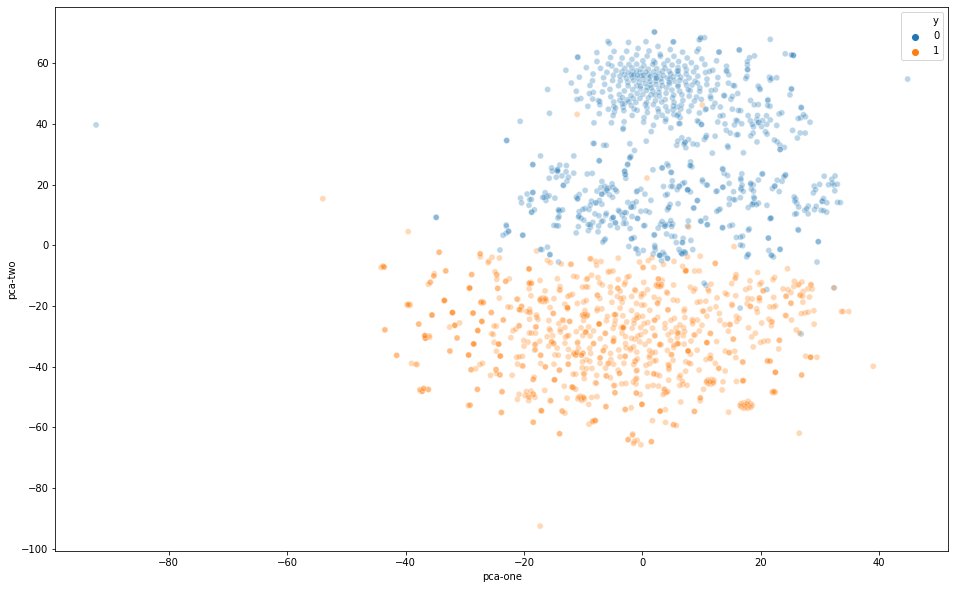

In [56]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="pca-one", y="pca-two",
    hue="y",
    data=df,
    legend="full",
    alpha=0.3
)

In [153]:
idf_vectorizer.vocabulary_['—Å–¥–∞–≤–∞—Ç—å']

16417

In [156]:
idf_vectorizer.get_feature_names()[17057]

'—Å–Ω–∏–º–∞—Ç—å'